<a href="https://colab.research.google.com/github/Mjh9122/ML_lit_review/blob/main/word2vec/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Efficient Estimation of Word Representations in Vector Space
## Authors: Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean
### Notes: Michael Holtz

### Abstract

They describe two NN architectures for embedding words into vector spaces. The quality is measured via a "word similarity task," and they find higher accuracy at much lower computational cost. Furthermore, the vectors produced provide state-of-the-art performance on a test set for syntactic and semantic word similarities.

### Intro

Many previous NLP systems treat words as simply an element in a set of words, with no notion of similarity between words. These simple techniques have notable limits in many tasks. While trillions of words might be necessary to achieve performance with these simple methods, tasks such as automatic speech recognition or machine translation may have corpora with only millions or billions of words. In these scenarios, a more complex strategy is needed.

### Paper Goals

The goal is to create high-quality vector embeddings for millions of words from a billion+ word corpora. The expectation of the embedding is that similar words should be close to one another and that words can have multiple degrees of similarity (such as a similar ending). More surprising is that algebraic operations on these vectors hold their meaning. Ex. King - man + woman = queen. They also develop a test set for syntactic and semantic regularities and discuss how time and accuracy depend on embedding dimension.


### Previous work

Previous attempts at word embeddings via a neural network language model. The first proposed models learned both a word vector representation and a statistical language model. Later architectures attempted to learn the embedding via a single hidden layer and then the vectors were used to train the NNLM. Other work also found that NLP tasks became easier when working with word vectors. The architecture in this paper seeks to find these vectors in a much more computationally efficient way.

### NNLM Architectures

#### Feedforward NNLM
This model takes in N-words encoded in one-of-V coding. The input layer is then projected to a projection layer P. This layer is passed to a hidden layer, which in turn predicts a probability distribution over the 1xV output layer.

#### Recurrent NNLM (RNNLM)
This model removes the need to specify the context length for the input. The RNNLM removes the projection layer, consisting of only input, hidden, and output layers. It is a recurrent architecture becuase there are time delayed connections from the hidden layer to itself. These connection theoretically allow for short term memory, allowing past words to influence future predictions.


### New log-linear models
The main focus of the paper. New models are proposed which avoid the nonlinear nature of the neural nets above, allowing for much more efficient training. These new models can then be used to train the above architectures on a much smaller input dimension.

#### CBOW
Continous bag of words (CBOW) is similar to the feedforward model but there is no non-linear hidden layer. Instead the projection layer is shared for all words, and input contains words from the past as well as the future. The goal is to classify the word in the middle of the input.

#### Imports

In [1]:
import torch
import torch.nn as nn
from nltk.tokenize import word_tokenize
from collections import Counter

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using: {device}')

Using: cuda


#### Import corpus and build datasets

In [2]:
with open('../datasets/the_cat_in_the_hat.txt', 'r') as f:
    text = f.read()
tokens = word_tokenize(text)
print("tokenized")
corpus = [word.lower()  for word in tokens if word.isalpha()][:10_000_000]
print("removed non-alpha")
word_counts = Counter(corpus)
print('words counted')
corpus = [word if word_counts[word] >= 5 else 'UNK' for word in corpus]
print('infrequent filtered')

tokenized
removed non-alpha
words counted
infrequent filtered


In [3]:
# Create vocab
vocab = set(corpus)
vocab_size = len(vocab)
print(f'vocab size: {vocab_size}')

# To convert from word to embedding index
word_to_ix = {word:ix for ix, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}

# Create dataset by taking four words on either side of a target word
context_length = 4
contexts, targets = [], []

for i in tqdm(range(context_length, len(corpus) - context_length)):
    context = corpus[i - context_length: i] + corpus[i + 1 : i + context_length + 1]
    target = corpus[i]
    targets.append(target)
    contexts.append(context)


CBOW_Xs = torch.tensor([[word_to_ix[w] for w in x] for x in contexts])
CBOW_ys = torch.tensor([word_to_ix[y] for y in targets])
SKIP_Xs, SKIP_ys = [], []

for context, target in tqdm(zip(contexts, targets), total = len(targets)):
    for ctxt_word in context:
        SKIP_Xs.append(word_to_ix[target])
        SKIP_ys.append(word_to_ix[ctxt_word])

SKIP_Xs = torch.tensor(SKIP_Xs)
SKIP_ys = torch.tensor(SKIP_ys)

print(f'CBOW training length: {CBOW_Xs.shape} Skipgram training length: {SKIP_ys.shape}')

vocab size: 89


100%|██████████| 1618/1618 [00:00<00:00, 1611967.67it/s]

CBOW training length: torch.Size([1618, 8]) Skipgram training length: torch.Size([12944])


#### Define dataset class

In [4]:
# Quick dataset class for dataloading
class Simple_Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.Y[idx],self.X[idx]

#### Define CBOW and Skipgram classes

In [5]:
# CBOW model proper. No non-linear activations like the paper says.
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, inputs):
        embeds = self.embeddings(inputs).sum(dim=1)
        out = self.linear(embeds)
        return out

    def get_word_embedding(self, word):
        word = torch.tensor(word_to_ix[word], device=self.device)
        return self.embeddings(word).view(1,-1)

In [6]:
# SKIPGRAM model. No non-linear activations. No negative sampling. 
class Skipgram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Skipgram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size, bias=False)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        out = self.linear(embeds)
        return out

    def get_word_embedding(self, word):
        word = torch.tensor(word_to_ix[word])
        return self.embeddings(word).view(1,-1)

#### CBOW Training

In [7]:
# Create cbow instance, loss, optimizer, dataset, and dataloader
batch_size = 256

model = CBOW(vocab_size, 50)
model.to(device)
loss = nn.CrossEntropyLoss(reduction='sum')
optim = torch.optim.Adam(model.parameters())

X_train, X_test, y_train, y_test = train_test_split(CBOW_Xs, CBOW_ys, test_size = .1)
trainset = Simple_Dataset(X_train, y_train)
testset = Simple_Dataset(X_test, y_test)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

len(trainset), len(testset)

(1456, 162)

In [8]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1000):
    train_correct = 0
    train_loss = 0
    test_correct = 0

    model.train()
    for labels, features in trainloader:
        labels, features = labels.to(device), features.to(device)
        optim.zero_grad()
        y_pred = model(features)
        l = loss(y_pred, labels)
        l.backward()
        optim.step()

        preds = torch.argmax(y_pred, dim=1)
        train_correct += (preds == labels).sum().item()
        train_loss += l.item()
    


    model.eval()
    with torch.no_grad():
        for labels, features in testloader:
            labels, features = labels.to(device), features.to(device)
            y_pred = model(features)
            preds = torch.argmax(y_pred, dim=1)
            test_correct += (preds == labels).sum().item()

    train_losses.append(train_loss/len(trainset))
    train_accuracies.append(train_correct/len(trainset))
    test_accuracies.append(test_correct/len(testset))

    if epoch % 100 == 99:
        print(f'Epoch: {epoch}')
        print('*'*40)
        print(f'Train Loss: {train_loss/len(trainset)}')
        print(f'Train Accuracy: {train_correct/len(trainset)}')
        print(f'Test Accuracy: {test_correct/len(testset)}')
        print()
    

Epoch: 99
****************************************
Train Loss: 1.7957572308215466
Train Accuracy: 0.5137362637362637
Test Accuracy: 0.30246913580246915

Epoch: 199
****************************************
Train Loss: 1.2001313744010507
Train Accuracy: 0.6785714285714286
Test Accuracy: 0.3148148148148148

Epoch: 299
****************************************
Train Loss: 0.8943057951036391
Train Accuracy: 0.7733516483516484
Test Accuracy: 0.2962962962962963

Epoch: 399
****************************************
Train Loss: 0.706917846595848
Train Accuracy: 0.8255494505494505
Test Accuracy: 0.29012345679012347

Epoch: 499
****************************************
Train Loss: 0.5818026092026259
Train Accuracy: 0.8523351648351648
Test Accuracy: 0.2777777777777778

Epoch: 599
****************************************
Train Loss: 0.49159089811555634
Train Accuracy: 0.8873626373626373
Test Accuracy: 0.2654320987654321

Epoch: 699
****************************************
Train Loss: 0.424660053881970

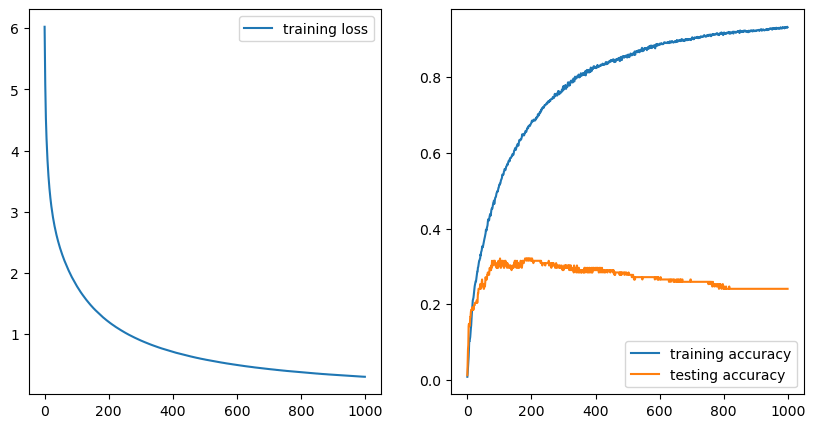

In [9]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].plot(train_losses, label = 'training loss')
axs[0].legend()
axs[1].plot(train_accuracies, label = 'training accuracy')
axs[1].plot(test_accuracies, label = 'testing accuracy')
axs[1].legend()

#### Skipgram Training

In [10]:
# Create Skipgram instance, loss, optimizer, dataset, and dataloader
batch_size = 256

model = Skipgram(vocab_size, 50)
model.to(device)
loss = nn.CrossEntropyLoss(reduction='sum')
optim = torch.optim.Adam(model.parameters())

X_train, X_test, y_train, y_test = train_test_split(SKIP_Xs, SKIP_ys, test_size = .1)
trainset = Simple_Dataset(X_train, y_train)
testset = Simple_Dataset(X_test, y_test)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

len(trainset), len(testset)

(11649, 1295)

In [11]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(100):
    train_correct = 0
    train_loss = 0
    test_correct = 0

    model.train()
    for labels, features in trainloader:
        labels, features = labels.to(device), features.to(device)
        optim.zero_grad()
        y_pred = model(features)
        l = loss(y_pred, labels)
        l.backward()
        optim.step()

        preds = torch.argmax(y_pred, dim=1)
        train_correct += (preds == labels).sum().item()
        train_loss += l.item()
    


    model.eval()
    with torch.no_grad():
        for labels, features in testloader:
            labels, features = labels.to(device), features.to(device)
            y_pred = model(features)
            preds = torch.argmax(y_pred, dim=1)
            test_correct += (preds == labels).sum().item()

    train_losses.append(train_loss/len(trainset))
    train_accuracies.append(train_correct/len(trainset))
    test_accuracies.append(test_correct/len(testset))

    if epoch % 10 == 9:
        print(f'Epoch: {epoch}')
        print('*'*40)
        print(f'Train Loss: {train_loss/len(trainset)}')
        print(f'Train Accuracy: {train_correct/len(trainset)}')
        print(f'Test Accuracy: {test_correct/len(testset)}')
        print()

Epoch: 9
****************************************
Train Loss: 3.7707587592601164
Train Accuracy: 0.17143102412224226
Test Accuracy: 0.16988416988416988

Epoch: 19
****************************************
Train Loss: 3.6068892752789603
Train Accuracy: 0.1900592325521504
Test Accuracy: 0.18532818532818532

Epoch: 29
****************************************
Train Loss: 3.5482199766552185
Train Accuracy: 0.1916044295647695
Test Accuracy: 0.18687258687258687

Epoch: 39
****************************************
Train Loss: 3.5156711968385834
Train Accuracy: 0.1920336509571637
Test Accuracy: 0.18687258687258687

Epoch: 49
****************************************
Train Loss: 3.492558586309883
Train Accuracy: 0.1922911837926002
Test Accuracy: 0.1891891891891892

Epoch: 59
****************************************
Train Loss: 3.4756594243730348
Train Accuracy: 0.19186196240020603
Test Accuracy: 0.18764478764478765

Epoch: 69
****************************************
Train Loss: 3.4623414867373943
T

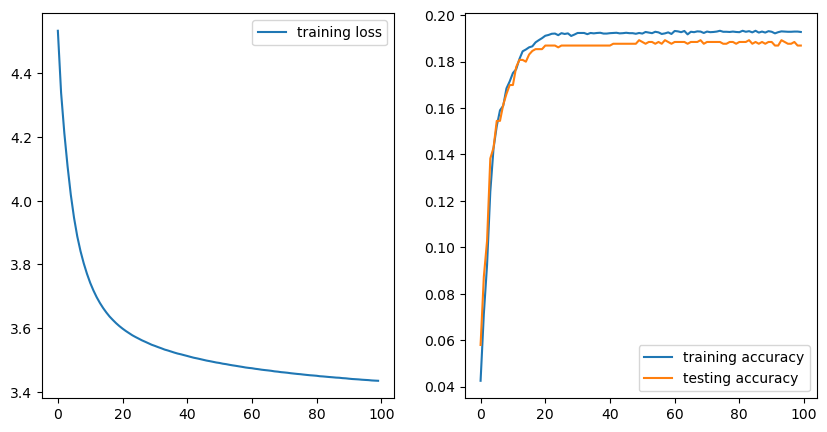

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].plot(train_losses, label = 'training loss')
axs[0].legend()
axs[1].plot(train_accuracies, label = 'training accuracy')
axs[1].plot(test_accuracies, label = 'testing accuracy')
axs[1].legend()